<a href="https://colab.research.google.com/github/suryakolluri6/HCM_diagnostic_models/blob/main/HCM_Diagnostic_Model_2_CSV_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import files
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import os
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras import regularizers
! pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 2.2 MB/s eta 0:00:00


In [2]:
import keras

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"suryakolluri","key":"dcf4f9d45975c7ae63f74cbc2b477a33"}'}

In [4]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d khyeh0719/ptb-xl-dataset --force

100% 1.72G/1.72G [01:18<00:00, 24.1MB/s]
100% 1.72G/1.72G [01:18<00:00, 23.4MB/s]


In [6]:
! ls

kaggle.json  ptb-xl-dataset.zip  sample_data


In [7]:
! unzip ptb-xl-dataset

Streaming output truncated to the last 5000 lines.
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19338_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19342_hr.dat  
  inflating: ptb-xl-a-large-publicly-availabl

In [8]:
os.chdir("ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1")

In [9]:
os.chdir('/content')

In [10]:
import pandas as pd
import numpy as np
import wfdb
import ast

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = '/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [11]:
print(X_train.shape)

(19634, 1000, 12)


In [12]:
print(X_test.shape)

(2203, 1000, 12)


In [13]:
print(y_train.shape)

(19634,)


In [14]:
print(y_test.shape)

(2203,)


In [15]:
print(X_train)

[[[-1.190e-01 -5.500e-02  6.400e-02 ... -2.600e-02 -3.900e-02 -7.900e-02]
  [-1.160e-01 -5.100e-02  6.500e-02 ... -3.100e-02 -3.400e-02 -7.400e-02]
  [-1.200e-01 -4.400e-02  7.600e-02 ... -2.800e-02 -2.900e-02 -6.900e-02]
  ...
  [ 6.900e-02  0.000e+00 -6.900e-02 ...  2.400e-02 -4.100e-02 -5.800e-02]
  [ 8.600e-02  4.000e-03 -8.100e-02 ...  2.420e-01 -4.600e-02 -9.800e-02]
  [ 2.200e-02 -3.100e-02 -5.400e-02 ...  1.430e-01 -3.500e-02 -1.200e-01]]

 [[ 4.000e-03  1.380e-01  1.340e-01 ...  1.920e-01  8.300e-02  8.800e-02]
  [-2.000e-02  1.160e-01  1.360e-01 ...  1.560e-01  5.700e-02  6.300e-02]
  [-5.300e-02  9.200e-02  1.450e-01 ...  1.070e-01  1.300e-02  2.200e-02]
  ...
  [ 1.210e-01  3.980e-01  2.770e-01 ... -1.065e+00 -4.920e-01 -1.560e-01]
  [-3.260e-01  5.700e-02  3.830e-01 ... -2.800e-01 -1.750e-01 -7.100e-02]
  [-3.480e-01 -5.600e-02  2.920e-01 ... -3.080e-01 -2.310e-01 -1.450e-01]]

 [[-2.900e-02 -7.900e-02 -4.900e-02 ... -1.030e-01 -7.600e-02 -6.600e-02]
  [-3.500e-02 -7.000e-

/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records100/10000


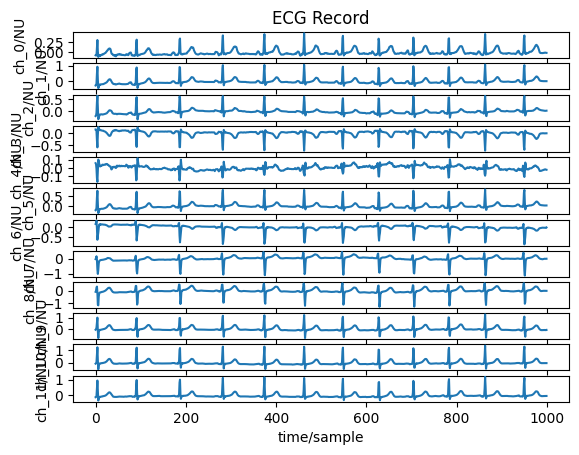

{'record_name': '10325_lr', 'n_sig': 12, 'fs': 100, 'counter_freq': None, 'base_counter': None, 'sig_len': 1000, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[-0.067, -0.252, -0.185, ..., -0.072, -0.075, -0.115],
       [-0.074, -0.24 , -0.166, ..., -0.03 , -0.051, -0.103],
       [-0.068, -0.119, -0.051, ...,  0.119,  0.047, -0.044],
       ...,
       [-0.005,  0.022,  0.027, ..., -0.094, -0.03 , -0.035],
       [-0.009,  0.021,  0.03 , ..., -0.106, -0.03 , -0.035],
       [-0.01 ,  0.02 ,  0.03 , ..., -0.091, -0.03 , -0.035]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['10325_lr.dat', '10325_lr.dat', '10325_lr.dat', '10325_lr.dat', '10325_lr.dat', '10325_lr.dat', '10325_lr.dat', '10325_lr.dat', '10325_lr.dat', '10325_lr.dat', '10325_lr.dat', '10325_lr.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16'], 

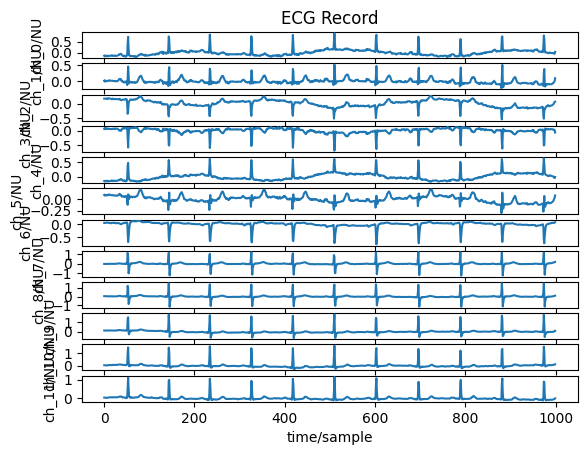

{'record_name': '10048_lr', 'n_sig': 12, 'fs': 100, 'counter_freq': None, 'base_counter': None, 'sig_len': 1000, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[-0.142,  0.023,  0.165, ...,  0.115,  0.025,  0.03 ],
       [-0.169, -0.004,  0.165, ...,  0.114,  0.023,  0.029],
       [-0.136,  0.028,  0.164, ...,  0.109,  0.017,  0.025],
       ...,
       [-0.048, -0.01 ,  0.038, ...,  0.022,  0.084, -0.052],
       [-0.045,  0.012,  0.057, ...,  0.021,  0.095, -0.038],
       [ 0.038,  0.101,  0.064, ...,  0.081,  0.101, -0.01 ]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['10048_lr.dat', '10048_lr.dat', '10048_lr.dat', '10048_lr.dat', '10048_lr.dat', '10048_lr.dat', '10048_lr.dat', '10048_lr.dat', '10048_lr.dat', '10048_lr.dat', '10048_lr.dat', '10048_lr.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16'], 

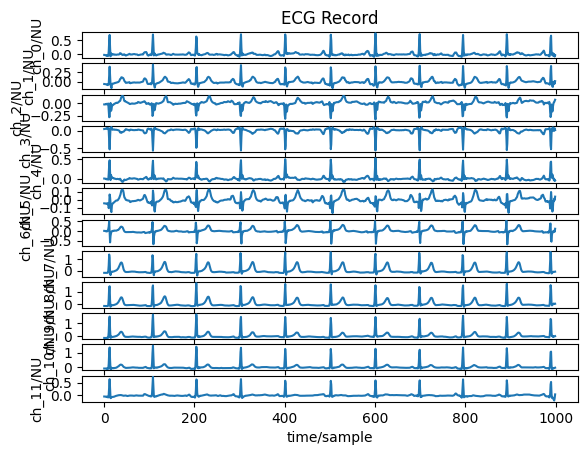

{'record_name': '10414_lr', 'n_sig': 12, 'fs': 100, 'counter_freq': None, 'base_counter': None, 'sig_len': 1000, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[-0.034, -0.064, -0.03 , ..., -0.169, -0.114, -0.054],
       [-0.035, -0.066, -0.031, ..., -0.17 , -0.115, -0.055],
       [-0.04 , -0.068, -0.028, ..., -0.171, -0.116, -0.059],
       ...,
       [-0.013,  0.004,  0.017, ..., -0.036, -0.073, -0.216],
       [-0.092, -0.053,  0.039, ..., -0.045, -0.07 , -0.119],
       [-0.049,  0.013,  0.062, ..., -0.026, -0.056,  0.031]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['10414_lr.dat', '10414_lr.dat', '10414_lr.dat', '10414_lr.dat', '10414_lr.dat', '10414_lr.dat', '10414_lr.dat', '10414_lr.dat', '10414_lr.dat', '10414_lr.dat', '10414_lr.dat', '10414_lr.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16'], 

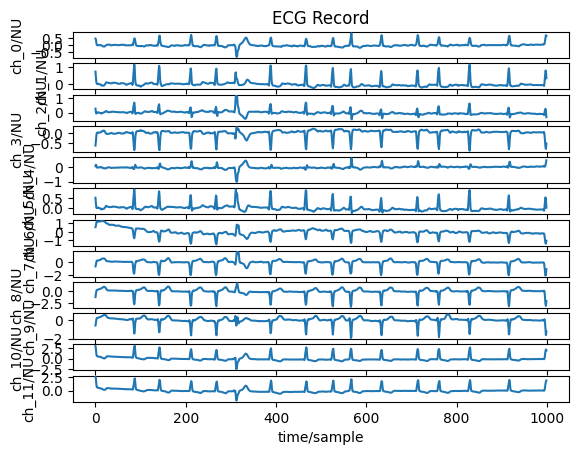

{'record_name': '10633_lr', 'n_sig': 12, 'fs': 100, 'counter_freq': None, 'base_counter': None, 'sig_len': 1000, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[ 0.459,  0.74 ,  0.282, ..., -0.606,  3.062,  2.492],
       [ 0.394,  0.418,  0.024, ..., -0.322,  2.325,  2.134],
       [ 0.149,  0.087, -0.063, ...,  0.064,  1.082,  1.113],
       ...,
       [ 0.525,  0.794,  0.269, ..., -1.011,  1.86 ,  1.187],
       [ 0.712,  0.802,  0.09 , ..., -1.629,  2.257,  1.649],
       [ 0.664,  0.344, -0.32 , ..., -1.26 ,  1.999,  1.824]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['10633_lr.dat', '10633_lr.dat', '10633_lr.dat', '10633_lr.dat', '10633_lr.dat', '10633_lr.dat', '10633_lr.dat', '10633_lr.dat', '10633_lr.dat', '10633_lr.dat', '10633_lr.dat', '10633_lr.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16'], 

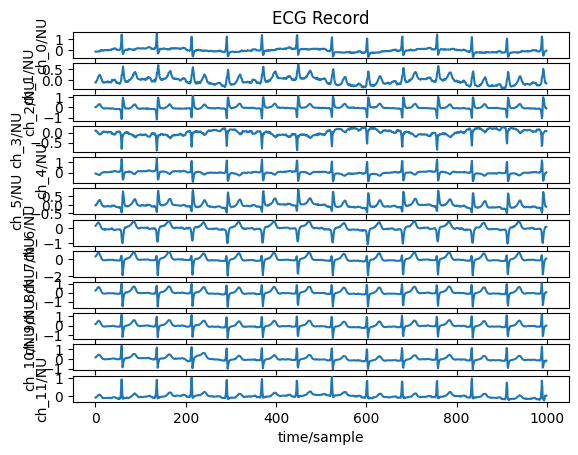

{'record_name': '10542_lr', 'n_sig': 12, 'fs': 100, 'counter_freq': None, 'base_counter': None, 'sig_len': 1000, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[-0.118, -0.089,  0.029, ...,  0.153,  0.148, -0.089],
       [-0.12 , -0.089,  0.031, ...,  0.174,  0.162, -0.079],
       [-0.101, -0.039,  0.062, ...,  0.251,  0.225, -0.065],
       ...,
       [-0.078, -0.121, -0.043, ..., -0.033, -0.217,  0.01 ],
       [-0.066, -0.122, -0.056, ..., -0.031, -0.261, -0.014],
       [-0.034, -0.127, -0.094, ..., -0.002, -0.18 ,  0.014]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['10542_lr.dat', '10542_lr.dat', '10542_lr.dat', '10542_lr.dat', '10542_lr.dat', '10542_lr.dat', '10542_lr.dat', '10542_lr.dat', '10542_lr.dat', '10542_lr.dat', '10542_lr.dat', '10542_lr.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16'], 

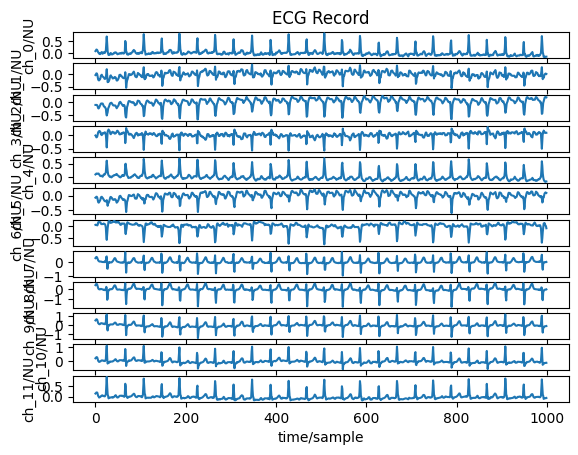

{'record_name': '10966_lr', 'n_sig': 12, 'fs': 100, 'counter_freq': None, 'base_counter': None, 'sig_len': 1000, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[ 0.075, -0.039, -0.115, ...,  0.535,  0.211,  0.15 ],
       [ 0.098, -0.017, -0.115, ...,  0.579,  0.24 ,  0.166],
       [ 0.142,  0.027, -0.115, ...,  0.654,  0.291,  0.199],
       ...,
       [-0.178,  0.02 ,  0.198, ..., -0.096, -0.121, -0.066],
       [-0.168,  0.015,  0.183, ..., -0.103, -0.131, -0.071],
       [-0.169,  0.005,  0.175, ..., -0.083, -0.12 , -0.061]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['10966_lr.dat', '10966_lr.dat', '10966_lr.dat', '10966_lr.dat', '10966_lr.dat', '10966_lr.dat', '10966_lr.dat', '10966_lr.dat', '10966_lr.dat', '10966_lr.dat', '10966_lr.dat', '10966_lr.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16'], 

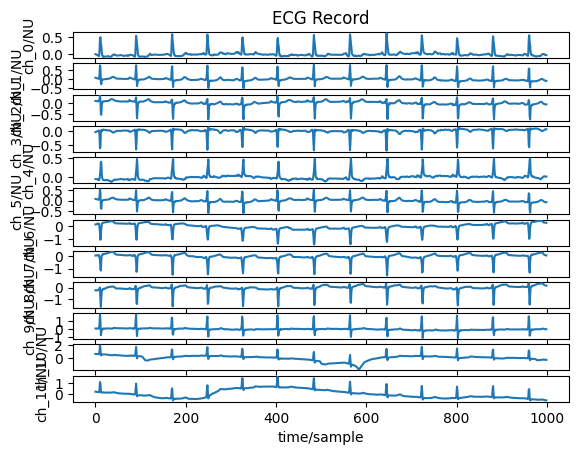

{'record_name': '10984_lr', 'n_sig': 12, 'fs': 100, 'counter_freq': None, 'base_counter': None, 'sig_len': 1000, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[-0.005,  0.079,  0.084, ...,  0.066,  0.59 ,  0.2  ],
       [-0.008,  0.076,  0.084, ...,  0.068,  0.59 ,  0.196],
       [-0.017,  0.063,  0.081, ...,  0.054,  0.581,  0.184],
       ...,
       [-0.028, -0.093, -0.066, ..., -0.013, -0.311, -0.596],
       [-0.031, -0.096, -0.064, ..., -0.019, -0.315, -0.593],
       [-0.029, -0.095, -0.065, ..., -0.026, -0.315, -0.596]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['10984_lr.dat', '10984_lr.dat', '10984_lr.dat', '10984_lr.dat', '10984_lr.dat', '10984_lr.dat', '10984_lr.dat', '10984_lr.dat', '10984_lr.dat', '10984_lr.dat', '10984_lr.dat', '10984_lr.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16'], 

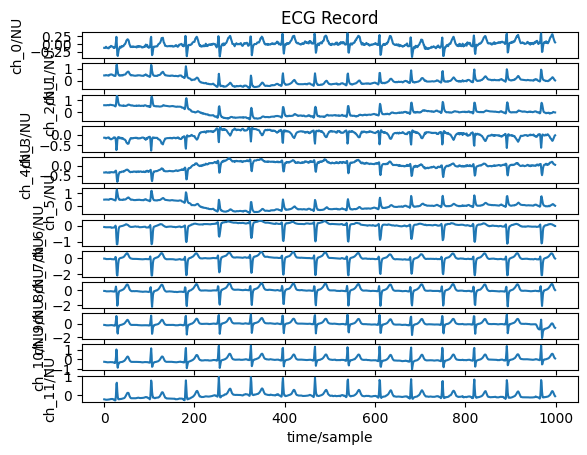

{'record_name': '10831_lr', 'n_sig': 12, 'fs': 100, 'counter_freq': None, 'base_counter': None, 'sig_len': 1000, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[-0.129,  0.43 ,  0.559, ..., -0.18 , -0.235, -0.201],
       [-0.129,  0.43 ,  0.56 , ..., -0.188, -0.24 , -0.208],
       [-0.132,  0.428,  0.56 , ..., -0.195, -0.244, -0.215],
       ...,
       [ 0.111,  0.08 , -0.03 , ..., -0.47 ,  0.206,  0.047],
       [ 0.07 ,  0.039, -0.031, ..., -0.567,  0.138, -0.012],
       [ 0.053,  0.017, -0.036, ..., -0.615,  0.103, -0.039]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['10831_lr.dat', '10831_lr.dat', '10831_lr.dat', '10831_lr.dat', '10831_lr.dat', '10831_lr.dat', '10831_lr.dat', '10831_lr.dat', '10831_lr.dat', '10831_lr.dat', '10831_lr.dat', '10831_lr.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16'], 

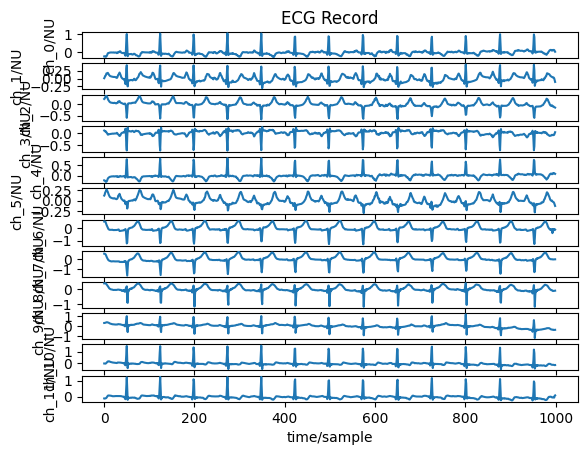

{'record_name': '10609_lr', 'n_sig': 12, 'fs': 100, 'counter_freq': None, 'base_counter': None, 'sig_len': 1000, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[-0.224,  0.01 ,  0.234, ...,  0.29 ,  0.   , -0.107],
       [-0.217,  0.034,  0.251, ...,  0.292, -0.003, -0.115],
       [-0.223,  0.079,  0.302, ...,  0.306, -0.012, -0.105],
       ...,
       [ 0.125,  0.002, -0.123, ..., -0.4  , -0.128, -0.053],
       [ 0.073, -0.059, -0.132, ..., -0.393, -0.141,  0.063],
       [ 0.033, -0.109, -0.143, ..., -0.391, -0.135,  0.085]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['10609_lr.dat', '10609_lr.dat', '10609_lr.dat', '10609_lr.dat', '10609_lr.dat', '10609_lr.dat', '10609_lr.dat', '10609_lr.dat', '10609_lr.dat', '10609_lr.dat', '10609_lr.dat', '10609_lr.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16'], 

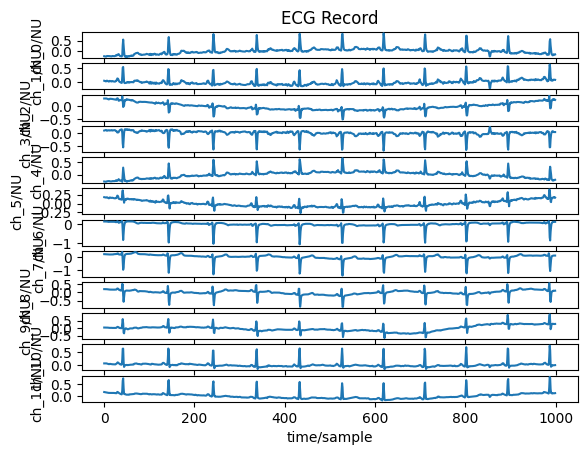

{'record_name': '10015_lr', 'n_sig': 12, 'fs': 100, 'counter_freq': None, 'base_counter': None, 'sig_len': 1000, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[-0.25 ,  0.055,  0.305, ...,  0.045,  0.06 ,  0.169],
       [-0.255,  0.05 ,  0.305, ...,  0.045,  0.06 ,  0.165],
       [-0.26 ,  0.045,  0.305, ...,  0.045,  0.06 ,  0.16 ],
       ...,
       [-0.167,  0.088,  0.255, ...,  0.279, -0.01 ,  0.115],
       [-0.174,  0.092,  0.267, ...,  0.282, -0.01 ,  0.118],
       [-0.165,  0.088,  0.253, ...,  0.284, -0.008,  0.121]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['10015_lr.dat', '10015_lr.dat', '10015_lr.dat', '10015_lr.dat', '10015_lr.dat', '10015_lr.dat', '10015_lr.dat', '10015_lr.dat', '10015_lr.dat', '10015_lr.dat', '10015_lr.dat', '10015_lr.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16'], 

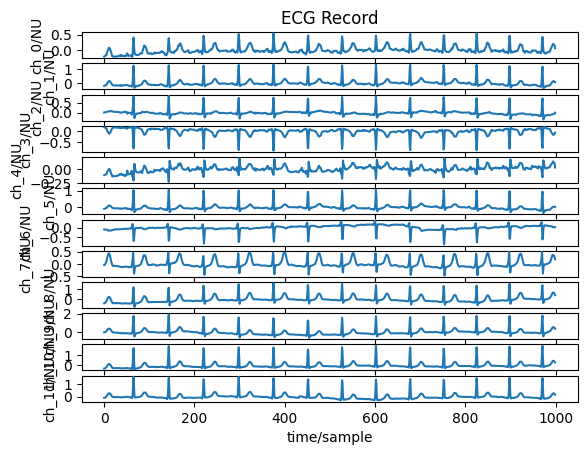

{'record_name': '10545_lr', 'n_sig': 12, 'fs': 100, 'counter_freq': None, 'base_counter': None, 'sig_len': 1000, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[-0.205, -0.195,  0.01 , ..., -0.01 , -0.294, -0.109],
       [-0.197, -0.185,  0.012, ...,  0.001, -0.287, -0.101],
       [-0.189, -0.171,  0.018, ...,  0.023, -0.273, -0.089],
       ...,
       [ 0.18 ,  0.123, -0.058, ...,  0.513,  0.403,  0.251],
       [ 0.145,  0.095, -0.05 , ...,  0.446,  0.346,  0.21 ],
       [ 0.062,  0.06 , -0.002, ...,  0.381,  0.284,  0.15 ]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['10545_lr.dat', '10545_lr.dat', '10545_lr.dat', '10545_lr.dat', '10545_lr.dat', '10545_lr.dat', '10545_lr.dat', '10545_lr.dat', '10545_lr.dat', '10545_lr.dat', '10545_lr.dat', '10545_lr.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16'], 

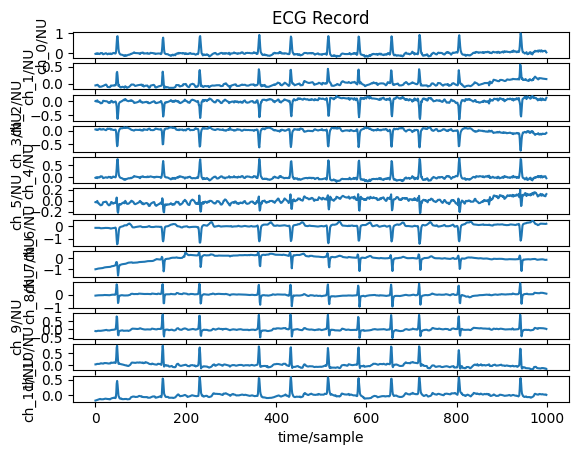

{'record_name': '10288_lr', 'n_sig': 12, 'fs': 100, 'counter_freq': None, 'base_counter': None, 'sig_len': 1000, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[-0.045, -0.05 , -0.005, ..., -0.106,  0.02 , -0.17 ],
       [-0.038, -0.048, -0.011, ..., -0.113,  0.021, -0.166],
       [-0.021, -0.041, -0.02 , ..., -0.112,  0.025, -0.161],
       ...,
       [ 0.106,  0.134,  0.029, ...,  0.043, -0.153,  0.023],
       [ 0.055,  0.135,  0.081, ...,  0.038, -0.154,  0.025],
       [ 0.029,  0.135,  0.106, ...,  0.024, -0.173,  0.012]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['10288_lr.dat', '10288_lr.dat', '10288_lr.dat', '10288_lr.dat', '10288_lr.dat', '10288_lr.dat', '10288_lr.dat', '10288_lr.dat', '10288_lr.dat', '10288_lr.dat', '10288_lr.dat', '10288_lr.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16'], 

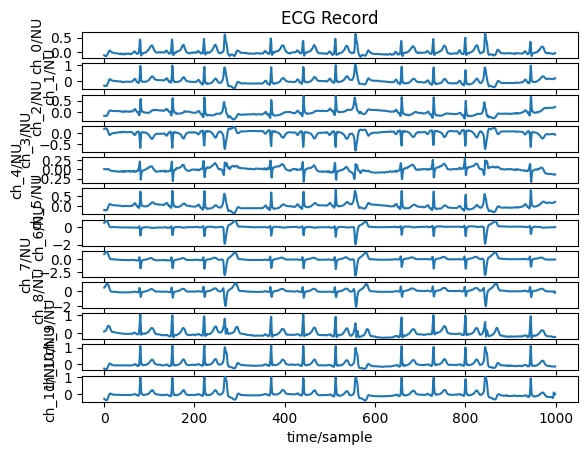

{'record_name': '10337_lr', 'n_sig': 12, 'fs': 100, 'counter_freq': None, 'base_counter': None, 'sig_len': 1000, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[-0.125, -0.271, -0.146, ...,  0.104, -0.278, -0.277],
       [-0.131, -0.288, -0.157, ...,  0.107, -0.293, -0.295],
       [-0.147, -0.307, -0.16 , ...,  0.128, -0.302, -0.316],
       ...,
       [-0.074,  0.144,  0.218, ..., -0.199, -0.168,  0.027],
       [-0.065,  0.153,  0.218, ..., -0.201, -0.161, -0.025],
       [-0.044,  0.183,  0.227, ..., -0.197, -0.149,  0.022]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['10337_lr.dat', '10337_lr.dat', '10337_lr.dat', '10337_lr.dat', '10337_lr.dat', '10337_lr.dat', '10337_lr.dat', '10337_lr.dat', '10337_lr.dat', '10337_lr.dat', '10337_lr.dat', '10337_lr.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16'], 

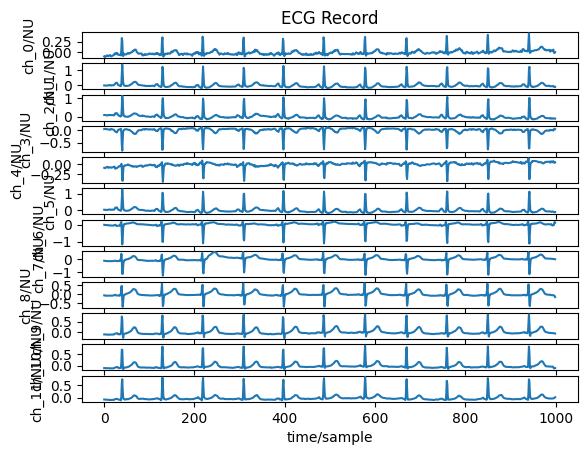

{'record_name': '10883_lr', 'n_sig': 12, 'fs': 100, 'counter_freq': None, 'base_counter': None, 'sig_len': 1000, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[-0.096, -0.01 ,  0.086, ..., -0.12 , -0.1  , -0.08 ],
       [-0.108, -0.016,  0.091, ..., -0.12 , -0.1  , -0.08 ],
       [-0.11 , -0.023,  0.086, ..., -0.12 , -0.101, -0.08 ],
       ...,
       [-0.017, -0.118, -0.102, ..., -0.064, -0.116, -0.02 ],
       [-0.009, -0.107, -0.098, ..., -0.071, -0.105, -0.003],
       [ 0.003, -0.104, -0.106, ..., -0.077, -0.103,  0.014]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['10883_lr.dat', '10883_lr.dat', '10883_lr.dat', '10883_lr.dat', '10883_lr.dat', '10883_lr.dat', '10883_lr.dat', '10883_lr.dat', '10883_lr.dat', '10883_lr.dat', '10883_lr.dat', '10883_lr.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16'], 

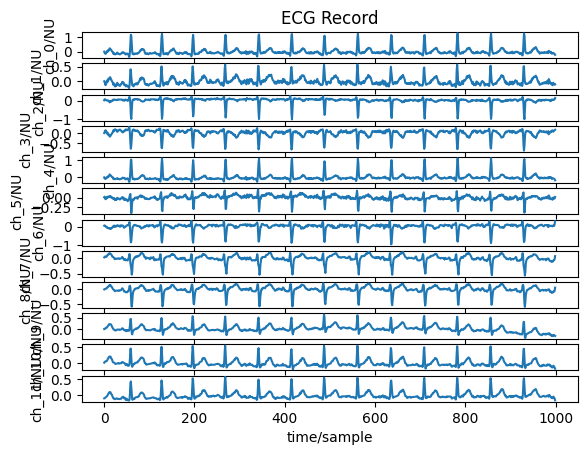

{'record_name': '10354_lr', 'n_sig': 12, 'fs': 100, 'counter_freq': None, 'base_counter': None, 'sig_len': 1000, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[-0.009,  0.004,  0.013, ..., -0.013,  0.012, -0.099],
       [-0.095, -0.023,  0.072, ..., -0.009,  0.034, -0.092],
       [-0.143, -0.099,  0.044, ..., -0.003,  0.044, -0.082],
       ...,
       [-0.151, -0.103,  0.048, ..., -0.287, -0.11 , -0.073],
       [-0.18 , -0.114,  0.066, ..., -0.314, -0.15 , -0.114],
       [-0.236, -0.102,  0.135, ..., -0.323, -0.179, -0.161]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['10354_lr.dat', '10354_lr.dat', '10354_lr.dat', '10354_lr.dat', '10354_lr.dat', '10354_lr.dat', '10354_lr.dat', '10354_lr.dat', '10354_lr.dat', '10354_lr.dat', '10354_lr.dat', '10354_lr.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16'], 

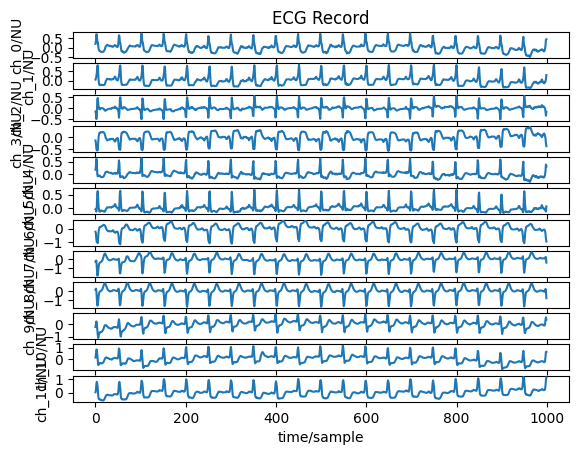

{'record_name': '10108_lr', 'n_sig': 12, 'fs': 100, 'counter_freq': None, 'base_counter': None, 'sig_len': 1000, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[ 0.206,  0.058, -0.148, ..., -0.24 ,  0.136,  0.017],
       [ 0.359,  0.118, -0.241, ..., -0.039,  0.354,  0.167],
       [ 0.721,  0.227, -0.494, ...,  0.201,  0.836,  0.619],
       ...,
       [ 0.096, -0.044, -0.14 , ...,  0.301,  0.169,  0.486],
       [ 0.421,  0.08 , -0.341, ...,  0.521,  0.628,  0.916],
       [ 0.451,  0.288, -0.164, ...,  0.35 ,  0.636,  1.102]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['10108_lr.dat', '10108_lr.dat', '10108_lr.dat', '10108_lr.dat', '10108_lr.dat', '10108_lr.dat', '10108_lr.dat', '10108_lr.dat', '10108_lr.dat', '10108_lr.dat', '10108_lr.dat', '10108_lr.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16'], 

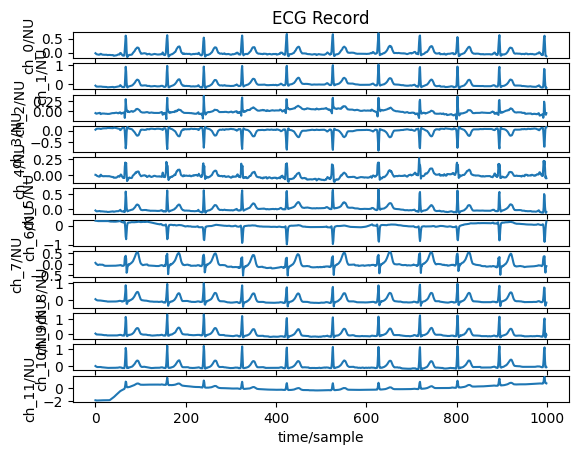

{'record_name': '10104_lr', 'n_sig': 12, 'fs': 100, 'counter_freq': None, 'base_counter': None, 'sig_len': 1000, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[-0.02 , -0.061, -0.04 , ...,  0.048,  0.008, -1.915],
       [-0.033, -0.081, -0.048, ...,  0.019, -0.013, -1.93 ],
       [-0.054, -0.108, -0.055, ..., -0.008, -0.032, -1.944],
       ...,
       [-0.103, -0.134, -0.031, ..., -0.21 , -0.064,  0.756],
       [-0.11 , -0.191, -0.081, ...,  0.044, -0.024,  0.734],
       [-0.127, -0.17 , -0.043, ..., -0.038, -0.058,  0.701]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['10104_lr.dat', '10104_lr.dat', '10104_lr.dat', '10104_lr.dat', '10104_lr.dat', '10104_lr.dat', '10104_lr.dat', '10104_lr.dat', '10104_lr.dat', '10104_lr.dat', '10104_lr.dat', '10104_lr.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16'], 

KeyboardInterrupt: ignored

In [ ]:
import wfdb
data_dir = '/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1'
for dirs, roots, files in os.walk('/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1'):
  for file in files:
    if file.endswith('.hea'):
      patient_id = file[:-4]
      print(dirs)
      record = wfdb.rdrecord(os.path.join(dirs, patient_id))
      header = wfdb.rdheader(os.path.join(dirs, patient_id))

      wfdb.plot_items(signal=record.p_signal, title= 'ECG Record')
      print(record.__dict__)

In [16]:
database = pd.read_csv('/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv')

In [17]:
len(pd.unique(database['patient_id']))

18885

In [18]:
(database['site'] == 0).sum()

8940

In [19]:
from collections import Counter
Counter(database['site'])

Counter({0.0: 8940,
         3.0: 611,
         2.0: 5075,
         1.0: 6296,
         35.0: 11,
         16.0: 22,
         4.0: 100,
         39.0: 8,
         32.0: 13,
         17.0: 20,
         9.0: 38,
         10.0: 37,
         34.0: 12,
         44.0: 7,
         11.0: 33,
         30.0: 12,
         36.0: 12,
         13.0: 24,
         5.0: 58,
         12.0: 26,
         38.0: 10,
         15.0: 25,
         25.0: 13,
         8.0: 43,
         14.0: 26,
         20.0: 18,
         29.0: 15,
         24.0: 14,
         21.0: 18,
         26.0: 15,
         6.0: 46,
         22.0: 15,
         18.0: 17,
         28.0: 15,
         45.0: 6,
         41.0: 9,
         49.0: 3,
         40.0: 9,
         37.0: 10,
         27.0: 15,
         43.0: 6,
         7.0: 43,
         19.0: 15,
         48.0: 4,
         42.0: 6,
         33.0: 10,
         23.0: 15,
         nan: 1,
         nan: 1,
         46.0: 4,
         50.0: 2,
         nan: 1,
         47.0: 4,
         nan:

In [20]:
label = np.array(y_train)

In [21]:
label

array([list(['NORM']), list(['NORM']), list(['NORM']), ...,
       list(['STTC']), list(['NORM']), list(['NORM'])], dtype=object)

In [22]:
print(y_train.shape)

(19634,)


In [23]:
y_train2 = []

In [24]:
for val in y_train:
  if 'HYP' in val:
    y_train2.append(1)

  else:
    y_train2.append(0)

In [25]:
print(len(y_train2))

19634


In [26]:
y_train = np.array(y_train2)

In [27]:
y_test2 = []

In [28]:
for val in y_test:
  if 'HYP' in val:
    y_test2.append(1)

  else:
    y_test2.append(0)

In [29]:
print(len(y_test2))

2203


In [30]:
y_test = np.array(y_test2)

In [31]:
Counter(y_test)

Counter({0: 1940, 1: 263})

In [32]:
print(y_test)

[0 0 0 ... 0 0 0]


In [33]:
from sklearn.preprocessing import MultiLabelBinarizer

In [34]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [36]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))

In [37]:
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

In [38]:
print(X_train_reshaped.shape)

(19634, 12000)


In [39]:
print(X_test_reshaped.shape)

(2203, 12000)


In [40]:
Counter(y_test)

Counter({0: 1940, 1: 263})

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
randomforest_model = RandomForestClassifier(n_estimators= 50)
randomforest_model.fit(X_train_reshaped, y_train)
randomforest_pred = randomforest_model.predict(X_test_reshaped)
randomforest_accuracy = randomforest_model.score(X_test_reshaped, y_test)
print(randomforest_accuracy)

0.8797094870630958


In [ ]:
print(randomforest_pred)

[0 0 0 ... 0 0 0]


In [ ]:
randomforest_pred = np.array(randomforest_pred)

In [ ]:
randomforest_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
confusionmatrix_randomforest = confusion_matrix(y_test, randomforest_pred)
precision = precision_score(y_test, randomforest_pred, pos_label = 1)
recall = recall_score(y_test, randomforest_pred, pos_label = 1)
f1score = 2*precision*recall/ (precision + recall)
print(confusionmatrix_randomforest, "\nPrecision:", precision, "\nRecall:", recall, "\nF1 Score:", f1score)

[[1923   17]
 [ 248   15]] 
Precision: 0.46875 
Recall: 0.057034220532319393 
F1 Score: 0.10169491525423728


In [ ]:
logreg_model = LogisticRegression(tol= 0.001, C = 0.1, random_state= 5, max_iter= 25)
logreg_model.fit(X_train_reshaped, y_train)
logreg_pred = logreg_model.predict(X_test_reshaped)
logreg_accuracy = logreg_model.score(X_test_reshaped, y_test)
print(logreg_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8669995460735361


In [ ]:
confusionmatrix_log = confusion_matrix(y_test, logreg_pred)
precision = precision_score(y_test, logreg_pred, pos_label = 1)
recall = recall_score(y_test, logreg_pred, pos_label = 1)
f1score = 2*precision*recall/ (precision + recall)
print(confusionmatrix_log, "\nPrecision:", precision, "\nRecall:", recall, "\nF1 Score:", f1score)

[[1892   48]
 [ 245   18]] 
Precision: 0.2727272727272727 
Recall: 0.06844106463878327 
F1 Score: 0.10942249240121579


In [ ]:
ridgeclass_model = RidgeClassifier(alpha=0.1, tol=0.0001, max_iter = 50)
ridgeclass_model.fit(X_train_reshaped, y_train)
ridge_pred = ridgeclass_model.predict(X_test_reshaped)
ridgeclass_accuracy = ridgeclass_model.score(X_test_reshaped, y_test)
print(ridgeclass_accuracy)

0.8488424875170223


In [ ]:
confusionmatrix_ridge = confusion_matrix(y_test, ridge_pred)
precision = precision_score(y_test, ridge_pred, pos_label = 1)
recall = recall_score(y_test, ridge_pred, pos_label = 1)
f1score = 2*precision*recall/ (precision + recall)
print(confusionmatrix_ridge, "\nPrecision:", precision, "\nRecall:", recall, "\nF1 Score:", f1score)

[[1839  101]
 [ 232   31]] 
Precision: 0.23484848484848486 
Recall: 0.11787072243346007 
F1 Score: 0.15696202531645567


In [ ]:
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train_reshaped, y_train)
decisiontree_pred = decisiontree.predict(X_test_reshaped)
decisiontree_accuracy = decisiontree.score(X_test_reshaped, y_test)
print(decisiontree_accuracy)

0.8261461643213799


In [ ]:
confusionmatrix_decisiontree = confusion_matrix(y_test, decisiontree_pred)
precision = precision_score(y_test, decisiontree_pred, pos_label = 1)
recall = recall_score(y_test, decisiontree_pred, pos_label = 1)
f1score = 2*precision*recall/ (precision + recall)
print(confusionmatrix_decisiontree, "\nPrecision:", precision, "\nRecall:", recall, "\nF1 Score:", f1score)

[[1746  194]
 [ 189   74]] 
Precision: 0.27611940298507465 
Recall: 0.2813688212927757 
F1 Score: 0.27871939736346524


In [ ]:
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
model.add(SimpleRNN(32, activation = 'relu'))

model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=20, batch_size=200, validation_data = (X_train, y_train), shuffle = True, class_weight = {0:1, 1:3})

Epoch 1/20
99/99 [==============================] - 148s 1s/step - loss: 0.7509 - accuracy: 0.8781 - val_loss: 0.4550 - val_accuracy: 0.8781
Epoch 2/20
99/99 [==============================] - 147s 1s/step - loss: 0.7508 - accuracy: 0.8781 - val_loss: 0.4619 - val_accuracy: 0.8781
Epoch 3/20
99/99 [==============================] - 146s 1s/step - loss: 0.7499 - accuracy: 0.8782 - val_loss: 0.4772 - val_accuracy: 0.8780
Epoch 4/20
99/99 [==============================] - 145s 1s/step - loss: 0.7496 - accuracy: 0.8781 - val_loss: 0.4661 - val_accuracy: 0.8781
Epoch 5/20
99/99 [==============================] - 146s 1s/step - loss: 0.7506 - accuracy: 0.8781 - val_loss: 0.4428 - val_accuracy: 0.8781
Epoch 6/20
99/99 [==============================] - 146s 1s/step - loss: 0.7510 - accuracy: 0.8782 - val_loss: 0.4486 - val_accuracy: 0.8782
Epoch 7/20
99/99 [==============================] - 146s 1s/step - loss: 0.7506 - accuracy: 0.8780 - val_loss: 0.4650 - val_accuracy: 0.8771
Epoch 8/20
99

In [ ]:
y_pred = model.predict(X_test)

69/69 [==============================] - 10s 142ms/step


In [ ]:
y_pred

array([[0.3079982 ],
       [0.22684473],
       [0.35117927],
       ...,
       [0.32376882],
       [0.32287523],
       [0.27127147]], dtype=float32)

In [ ]:
y_pred_binary = np.round(y_pred).astype(int)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(accuracy, '\n', precision, "\n", recall)

0.8806173399909215 
 0.0 
 0.0


In [ ]:
y_pred_binary

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
y_test

In [ ]:
X_train

In [ ]:
X_train_reshaped

In [82]:
from keras.layers import LSTM, Dropout, GlobalMaxPooling1D, BatchNormalization, Bidirectional, MaxPooling1D, Conv1D, Flatten, Conv2D, MaxPooling2D, TimeDistributed

In [91]:
lstm = Sequential()
lstm.add(Bidirectional(LSTM(units=64, input_shape = (1000, 12), return_sequences = True)))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(units=32, return_sequences = True)))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(units=16, return_sequences = True)))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(units=32, return_sequences = True)))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(units=64, return_sequences = True)))
lstm.add(GlobalMaxPooling1D())

lstm.add(Dense(units = 32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
lstm.add(Dense(units=16, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
lstm.add(Dense(units = 4, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
lstm.add(BatchNormalization())
lstm.add(Dense(units = 1, activation='sigmoid'))

In [92]:
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [93]:
lstm.fit(X_train, y_train, epochs=25, batch_size=200, validation_data = (X_test, y_test), shuffle = True, class_weight = {0:1, 1:3})

Epoch 1/25
99/99 [==============================] - 57s 394ms/step - loss: 0.7180 - accuracy: 0.7572 - val_loss: 0.5752 - val_accuracy: 0.9042
Epoch 2/25
99/99 [==============================] - 36s 362ms/step - loss: 0.5810 - accuracy: 0.8631 - val_loss: 0.4442 - val_accuracy: 0.8779
Epoch 3/25
99/99 [==============================] - 36s 360ms/step - loss: 0.5009 - accuracy: 0.8809 - val_loss: 0.2771 - val_accuracy: 0.9147
Epoch 4/25
99/99 [==============================] - 36s 362ms/step - loss: 0.4671 - accuracy: 0.8868 - val_loss: 0.3468 - val_accuracy: 0.8797
Epoch 5/25
99/99 [==============================] - 36s 361ms/step - loss: 0.4364 - accuracy: 0.8946 - val_loss: 0.2533 - val_accuracy: 0.9079
Epoch 6/25
99/99 [==============================] - 36s 362ms/step - loss: 0.4278 - accuracy: 0.8967 - val_loss: 0.3608 - val_accuracy: 0.8561
Epoch 7/25
99/99 [==============================] - 36s 361ms/step - loss: 0.4142 - accuracy: 0.8967 - val_loss: 0.2814 - val_accuracy: 0.8947

In [94]:
y_pred = lstm.predict(X_test)

69/69 [==============================] - 9s 93ms/step


In [95]:
y_pred_binary = np.round(y_pred).astype(int)

In [96]:
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1score = 2*precision*recall/ (precision + recall)

In [97]:
print('Accuracy:', accuracy, '\nPrecision', precision, '\nRecall', recall, "F1 Score:", f1score)

Accuracy: 0.9155696777122107 
Precision 0.7391304347826086 
Recall 0.4524714828897338 F1 Score: 0.5613207547169811


In [98]:
print(confusion_matrix(y_test, y_pred_binary))

[[1898   42]
 [ 144  119]]


In [104]:
sum(y_test)

263

In [ ]:
cnn = Sequential()
for i in range(3):
  cnn.add(Conv1D(filters = 16, kernel_size = 5, activation = 'relu', input_shape = (1000,12)))
  cnn.add(Dropout(0.3))
  cnn.add(Conv1D(filters = 32, kernel_size = 5, activation = 'relu'))
  cnn.add(Dropout(0.3))
  cnn.add(Conv1D(filters = 64, kernel_size = 5, activation = 'relu'))
  cnn.add(MaxPooling1D(pool_size = 2))

cnn.add(Flatten())
cnn.add(Dense(128, activation = 'relu', kernel_regularizer = regularizers.l2(0.0001)))
cnn.add(Dropout(0.3))
cnn.add(Dense(64, activation = 'relu', kernel_regularizer = regularizers.l2(0.0001)))
cnn.add(Dropout(0.3))
cnn.add(Dense(16, activation = 'relu', kernel_regularizer = regularizers.l2(0.0001)))
cnn.add(Dropout(0.4))
cnn.add(Dense(4, activation = 'relu', kernel_regularizer = regularizers.l2(0.0001)))
cnn.add(Dropout(0.4))
cnn.add(BatchNormalization())
cnn.add(Dense(1, activation = 'sigmoid'))

In [ ]:
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
cnn.fit(X_train, y_train, epochs=30, batch_size=200, validation_data = (X_test, y_test), shuffle = True, class_weight = {0:1, 1:5})

Epoch 1/30
99/99 [==============================] - 10s 46ms/step - loss: 0.9849 - accuracy: 0.8235 - val_loss: 0.6298 - val_accuracy: 0.8820
Epoch 2/30
99/99 [==============================] - 4s 41ms/step - loss: 0.8998 - accuracy: 0.8638 - val_loss: 0.5451 - val_accuracy: 0.8820
Epoch 3/30
99/99 [==============================] - 4s 41ms/step - loss: 0.8525 - accuracy: 0.8751 - val_loss: 0.4771 - val_accuracy: 0.8865
Epoch 4/30
99/99 [==============================] - 4s 41ms/step - loss: 0.8361 - accuracy: 0.8773 - val_loss: 0.4470 - val_accuracy: 0.8911
Epoch 5/30
99/99 [==============================] - 4s 41ms/step - loss: 0.8182 - accuracy: 0.8833 - val_loss: 0.4246 - val_accuracy: 0.9056
Epoch 6/30
99/99 [==============================] - 4s 42ms/step - loss: 0.7992 - accuracy: 0.8833 - val_loss: 0.4056 - val_accuracy: 0.9088
Epoch 7/30
99/99 [==============================] - 4s 41ms/step - loss: 0.7974 - accuracy: 0.8849 - val_loss: 0.4191 - val_accuracy: 0.8915
Epoch 8/30
9

In [ ]:
cnn_pred = cnn.predict(X_test)

69/69 [==============================] - 0s 3ms/step


In [ ]:
cnn_pred

array([[0.21697201],
       [0.21697201],
       [0.21697201],
       ...,
       [0.21697201],
       [0.21697201],
       [0.21697201]], dtype=float32)

In [ ]:
cnn_pred_binary = np.round(cnn_pred).astype(int)

In [ ]:
accuracy = accuracy_score(y_test, cnn_pred_binary)
precision = precision_score(y_test, cnn_pred_binary)
recall = recall_score(y_test, cnn_pred_binary)
f1score = 2*precision*recall/ (precision + recall)

In [ ]:
print('Accuracy:', accuracy, '\nPrecision', precision, '\nRecall', recall, "F1 Score:", f1score)

Accuracy: 0.9024058102587381 
Precision 0.875 
Recall 0.21292775665399238 F1 Score: 0.3425076452599388


In [ ]:
from keras.layers import GRU
from keras.regularizers import l2

In [ ]:
gru = Sequential()
gru.add(GRU(16, input_shape = (1000,12), kernel_regularizer = l2(0.0001)))
gru.add(Dropout(0.4))
gru.add(Dense(64, activation = 'relu'))
gru.add(Dropout(0.4))
gru.add(Dense(16, activation = 'relu'))
gru.add(Dropout(0.4))
gru.add(Dense(4, activation = 'relu'))
gru.add(Dropout(0.4))
gru.add(BatchNormalization())
gru.add(Dense(1, activation = 'relu', kernel_regularizer = l2(0.0001)))

In [ ]:
gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gru.fit(X_train, y_train, batch_size=200, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
99/99 [==============================] - 9s 41ms/step - loss: 0.8959 - accuracy: 0.8610 - val_loss: 0.8417 - val_accuracy: 0.8806
Epoch 2/30
99/99 [==============================] - 3s 33ms/step - loss: 0.7251 - accuracy: 0.8693 - val_loss: 0.5631 - val_accuracy: 0.8806
Epoch 3/30
99/99 [==============================] - 3s 33ms/step - loss: 0.6106 - accuracy: 0.8745 - val_loss: 0.4407 - val_accuracy: 0.8806
Epoch 4/30
99/99 [==============================] - 4s 39ms/step - loss: 0.5282 - accuracy: 0.8752 - val_loss: 0.3923 - val_accuracy: 0.8806
Epoch 5/30
99/99 [==============================] - 3s 33ms/step - loss: 0.4780 - accuracy: 0.8764 - val_loss: 0.3742 - val_accuracy: 0.8806
Epoch 6/30
99/99 [==============================] - 3s 32ms/step - loss: 0.4532 - accuracy: 0.8761 - val_loss: 0.3736 - val_accuracy: 0.8806
Epoch 7/30
99/99 [==============================] - 4s 38ms/step - loss: 0.4501 - accuracy: 0.8771 - val_loss: 0.3736 - val_accuracy: 0.8806
Epoch 8/30
99

In [ ]:
gru_pred = gru.predict(X_test)

69/69 [==============================] - 2s 20ms/step


In [ ]:
gru_pred_binary = np.round(gru_pred).astype(int)

In [ ]:
accuracy = accuracy_score(y_test, gru_pred_binary)
precision = precision_score(y_test, gru_pred_binary)
recall = recall_score(y_test, gru_pred_binary)
f1score = 2*precision*recall/ (precision + recall)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-51-5c717e063ca8>:4: RuntimeWarning: invalid value encountered in double_scalars
  f1score = 2*precision*recall/ (precision + recall)


In [ ]:
print('Accuracy:', accuracy, '\nPrecision', precision, '\nRecall', recall, "F1 Score:", f1score)

Accuracy: 0.8806173399909215 
Precision 0.0 
Recall 0.0 F1 Score: nan


In [ ]:
import pywt

In [ ]:
X_train.shape

(19634, 1000, 12)

In [ ]:
coeffs_train = []
for lead in range(X_train.shape[2]):
    lead_coeffs = []
    for sample in range(X_train.shape[0]):
        cA, cD = pywt.dwt(X_train[sample, :, lead], 'db4')
        lead_coeffs.append(cA)
    coeffs_train.append(lead_coeffs)

In [ ]:
coeffs_test = []
for lead in range(X_test.shape[2]):
    lead_coeffs = []
    for sample in range(X_test.shape[0]):
        cA, cD = pywt.dwt(X_test[sample, :, lead], 'db4')  # Apply the discrete wavelet transform
        lead_coeffs.append(cA)
    coeffs_test.append(lead_coeffs)

In [ ]:
X_train_wavelet = np.array(coeffs_train)
X_test_wavelet = np.array(coeffs_test)

In [ ]:
X_train_wavelet.shape

(19634, 503, 12)

In [ ]:
X_train_wavelet = np.transpose(X_train_wavelet, (1, 2, 0))
X_test_wavelet = np.transpose(X_test_wavelet, (1, 2, 0))

In [ ]:
wavelet_lstm = Sequential()
wavelet_lstm.add(Bidirectional(LSTM(units=64, input_shape = (503, 12), return_sequences = True)))
wavelet_lstm.add(Dropout(0.3))
wavelet_lstm.add(Bidirectional(LSTM(units=32, return_sequences = True)))
wavelet_lstm.add(Dropout(0.3))
wavelet_lstm.add(Bidirectional(LSTM(units=16, return_sequences = True)))
wavelet_lstm.add(GlobalMaxPooling1D())
wavelet_lstm.add(Dropout(0.2))
wavelet_lstm.add(Dense(units = 16, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
wavelet_lstm.add(BatchNormalization())
wavelet_lstm.add(Dense(units=8, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
wavelet_lstm.add(Dropout(0.2))
wavelet_lstm.add(BatchNormalization())
wavelet_lstm.add(Dense(units = 1, activation='sigmoid'))

In [ ]:
wavelet_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
X_train_wavelet.shape

(19634, 503, 12)

In [ ]:
X_test_wavelet.shape

(2203, 503, 12)

In [ ]:
wavelet_lstm.fit(X_train_wavelet, y_train, epochs=35, batch_size=200, validation_data = (X_test_wavelet, y_test), shuffle = True, class_weight = {0:1, 1:2})

Epoch 1/35
99/99 [==============================] - 26s 138ms/step - loss: 0.7305 - accuracy: 0.7403 - val_loss: 0.5354 - val_accuracy: 0.8865
Epoch 2/35
99/99 [==============================] - 12s 117ms/step - loss: 0.5892 - accuracy: 0.8417 - val_loss: 0.4296 - val_accuracy: 0.8888
Epoch 3/35
99/99 [==============================] - 11s 116ms/step - loss: 0.5099 - accuracy: 0.8746 - val_loss: 0.3348 - val_accuracy: 0.9010
Epoch 4/35
99/99 [==============================] - 11s 115ms/step - loss: 0.4426 - accuracy: 0.8952 - val_loss: 0.3147 - val_accuracy: 0.8933
Epoch 5/35
99/99 [==============================] - 11s 115ms/step - loss: 0.4190 - accuracy: 0.9011 - val_loss: 0.2675 - val_accuracy: 0.9088
Epoch 6/35
99/99 [==============================] - 11s 115ms/step - loss: 0.3898 - accuracy: 0.9082 - val_loss: 0.2670 - val_accuracy: 0.9042
Epoch 7/35
99/99 [==============================] - 11s 115ms/step - loss: 0.3776 - accuracy: 0.9080 - val_loss: 0.2542 - val_accuracy: 0.9051

In [ ]:
lstm_wavelet_pred = wavelet_lstm.predict(X_test_wavelet)
lstm_wavelet_pred_binary = np.round(lstm_wavelet_pred).astype(int)

69/69 [==============================] - 4s 31ms/step


In [ ]:
accuracy = accuracy_score(y_test, lstm_wavelet_pred_binary)
precision = precision_score(y_test, lstm_wavelet_pred_binary)
recall = recall_score(y_test, lstm_wavelet_pred_binary)
f1score = 2*precision*recall/ (precision + recall)
print('Accuracy:', accuracy, '\nPrecision', precision, '\nRecall', recall, "F1 Score:", f1score)

Accuracy: 0.9110304130730822 
Precision 0.7410071942446043 
Recall 0.3916349809885932 F1 Score: 0.5124378109452736


In [105]:
import joblib
!pip install streamlit --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 40.1 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=b745860edbe166ac400395f233fcc76cb5fbc56154c2be53be31123d42dfd31b
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators
  Attempting uninstall: tzlocal
    Found existing installation: tzlocal 5.0.1
    Uninstalling tzloc

In [106]:
from joblib import dump, load
!pip install pyngrok
from pyngrok import ngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=45dfd245242d835ef71279ed69330554fe3e4d5576cd978099d284c3ef75b787
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok


In [107]:
!pip install ngrok --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.7 MB/s eta 0:00:00


In [108]:
dump(lstm,'ekg_lstm_model.joblib')

['ekg_lstm_model.joblib']

In [109]:
import streamlit as st

In [110]:
%%writefile header.py
import streamlit as st

def create_header():
  st.title("Inspirit AI: Hypertrophic Cardiomyopathy Model")
  st.header("By Surya Kolluri")
  st.subheader("Given EKG .dat and .hea files or a CMR scan, predict whether or not a patient has hypertrophic cardiomyopathy.")

Writing header.py


In [111]:
%%writefile userinput.py
import streamlit as st

def get_user_input():
  choice = ['CMR', 'EKG']
  choice = st.selectbox('Select an option: ', choice)
  if choice == 'CMR':
    file = st.file_uploader('CMR .jpg file here: ', type = '.jpg')

  else:
    files = st.file_uploader('Upload .hea and .dat files here: ', accept_multiple_files = True, type = ['hea', 'dat'])
    files = files.values()

  input_features = [choice, file]

  return input_features

Writing userinput.py


In [112]:
%%writefile predictor.py

def make_prediction(model, input):
  return round(model.predict(input), 0)

Writing predictor.py


In [113]:
%%writefile response.py
import streamlit as st

def get_app_response(prediction):
  if prediction == 1:
    st.write("The model you chose predicts the scan is HCM-positive.")
  else:
    st.write("The model you chose predicts the scan is HCM-negative.")

Writing response.py


In [131]:
def launch_website():
    ! streamlit hello
    st.write("Click this link to try your web app:")
    public_url = ngrok.connect(addr="localhost:8501")
    st.write(f"Public URL: {public_url}")
    st.run('app.py')

In [136]:
%%writefile app.py
import streamlit as st
st.set_option('browser.gatherUsageStats', False)
from joblib import load

from header import *
from userinput import *
from response import *
from predictor import *

model = load('ekg_lstm_model.joblib')

create_header()
input_features = get_user_input()
prediction = make_prediction(model, input_features)
get_app_response(prediction)

Overwriting app.py


In [116]:
!ngrok authtoken 2Ap25X6Vhmysbp1TM0yCkHRxZsP_4HoDgxjb6fuREqoFaLbDX

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [135]:
launch_website()




  Welcome to Streamlit. Check out our demo in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.126.159.45:8501

  Ready to create your own Python apps super quickly?
  Head over to https://docs.streamlit.io

  May you create awesome apps!


  Stopping...
  Stopping...


AttributeError: ignored